In [2]:
import sys
sys.path.append('../src')

import importlib
import dyn_accept_loop as dal
importlib.reload(dal)
import reject_inference as rinf
importlib.reload(rinf)
import helper as h
importlib.reload(h)

import matplotlib.pyplot as plt

import lightgbm as lgbm
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

import lightgbm as lgbm

### Acceptance Loop and Sampling Bias

The sampling bias is created through the so called Acceptance Loop. Since we are unable to know the true label of a rejected credit application, we are left with no other option, than to train our model on data points that itself once accepted. This is creating a loop, which is marked red in the following graph.

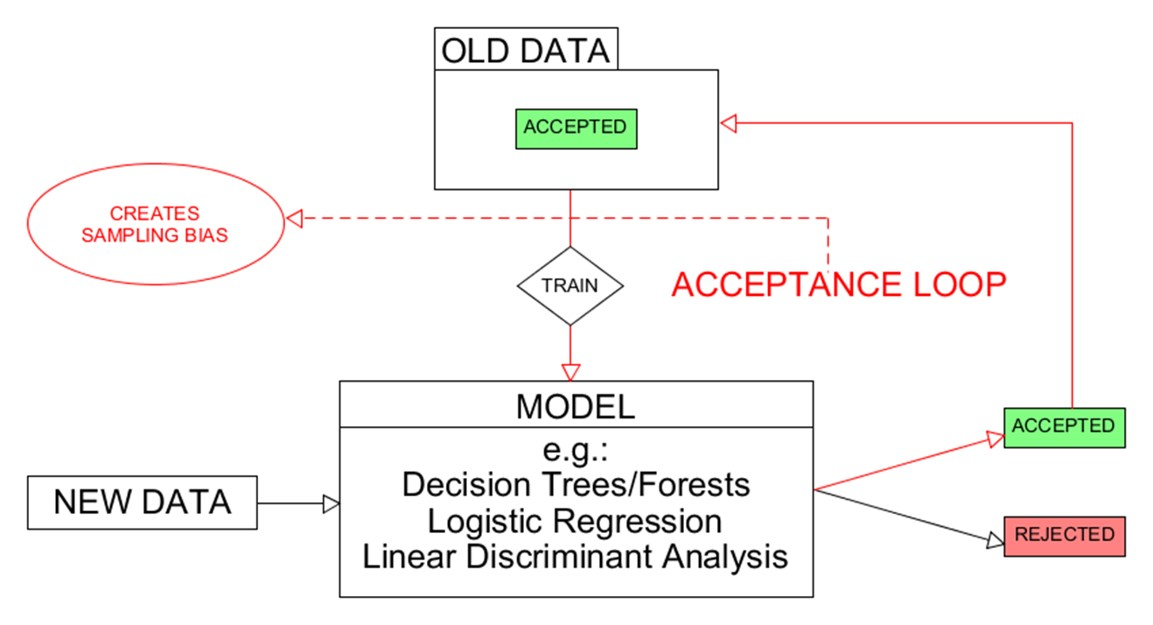

In order to test any sampling bias minimizing reject inference methods, we need to measure the baseline sampling bias. This can be done fairly easily by simulating the above-described process of rating loan applications and iteratively retrain the rating model on additional cases it accepted previously. To then be able to measure the bias we can compare the performance of the credit scoring model over time to a second model, we call oracle, that was retrained on additional accepted and rejected cases in each iteration. This oracle model is not possible in the real world but serves as a theoretically possible baseline for our tests, incorporating all the available information that we try to recover with our reject inference methods. An overview of how we operate the model and the oracle can be seen here.

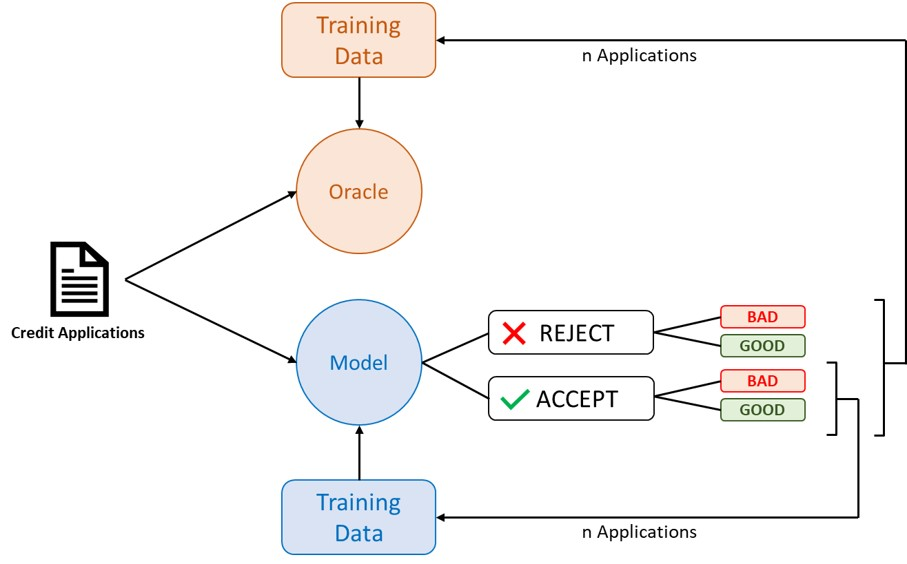

We have developed a dedicated class, handling our credit scoring simulations. It allows for various different experimental setups and keeps track of a variety of metrics to evaluate and compare results. In the following section we will describe critical code blocks of that class in the notebook, but to be useful this class is of course contained in a separate py file that is imported when we test our autoencoder.

Let us first have a look at the constructor for that class, that handles all the data loading and preparation for the subsequent simulation and thus already receives a lot of parameters.

In [ ]:
class Simulate_acceptance_loop():

    def __init__(self, dataset_name: str, model, model_fit_split: float, holdout_test_split: float, n_loops: int, enc_features: bool = False, encoder: aenc.Autoencoder = None, rej_inf = None, incl_rejected: bool = False):
        self.n_loops = n_loops
        self.rej_inf = rej_inf

        # custom Transformer, that standard scales and then encodes the data with Autoencoder "encoder"
        def std_enco(x):
            x_np = x.values.reshape(-1, x.shape[1]).astype('float32')
            x_trans = pre.StandardScaler().fit_transform(x_np)
            with torch.no_grad():
                x_encoded = encoder.encode(torch.from_numpy(x_trans)).numpy()
            return x_encoded

        # Either normal StandardScaler or StandardScaler and Encoder
        if enc_features:
            self.transformer  =  pre.FunctionTransformer(std_enco)
        else:
            self.transformer  = pre.StandardScaler()

>We will explore all the constructors’ parameters as we progress in the code. In the very first part of the initialization we make the most important decision for the subsequent simulation: whether we want to run it on the original (standard scaled, however) or on the encoded features. If _enc_features_ is set to true, we must provide a trained `Autoencoder` _encoder_ as a parameter, that will encode data via a custom sklearn FunctionTransformer. Of course before the data is encoded it is also standard scaled.
>
>The class allows for an optional parameter _rej_inf_, that must be a function that trains a model. This allows for some alternative, simpler reject inference methods, that rely on training models with specially weighted datapoints to fight sampling bias.

In [ ]:
        # load dataset
        complete_data = pd.read_csv(f'../prepared_data/{dataset_name}', sep=',')
        complete_data['BAD'] = np.where(complete_data['BAD'] == 'BAD', 1, 0).astype(np.int64)

        obj_cols = complete_data.select_dtypes('object').columns
        complete_data[obj_cols] = complete_data[obj_cols].astype('category')

        # For the sake of simplicity when dealing with neural nets later, let's just make everything categorical continous
        for col in obj_cols:
            woe_calc = h.IV_Calc(complete_data, feature=col, target='BAD')
            woe = woe_calc.full_summary()['WOE_adj'].to_dict()
            complete_data[col] = complete_data[col].map(woe)
            complete_data[col] = complete_data[col].astype('float64')

        complete_X = complete_data.iloc[:, complete_data.columns != 'BAD']
        complete_y = complete_data['BAD']

>Another important aspect follows, after the data is loaded by datasetname from the prepared_data folder. In oder to make things a lot easier when testing different models and more importantly when handling the Autoencoder, we transform every non-numerical feature to be represented in terms of `Weight of Evidence`. We then split our features from the target.

In [ ]:
        # get part of the data for inital model fitting
        X_remaining, X_model_fit, y_remaining, y_model_fit = train_test_split(complete_X, complete_y, test_size=model_fit_split, stratify=complete_y, random_state=123)

        # reserve holdout data for model evaluation
        X_simulation, X_holdout, y_simulation, y_holdout = train_test_split(X_remaining, y_remaining, test_size=holdout_test_split, stratify=y_remaining, random_state=123)

        self.holdout_test_X = X_holdout
        self.holdout_test_y = y_holdout

        # put simulation data back together
        self.simulation_data = pd.concat([X_simulation, y_simulation], axis=1)

        # initial fit of model and oracle model on remaining data
        self.model = model
        self.oracle = clone(model)

        self.transformer.fit(X_model_fit)
        X_model_fit_trans = self.transformer.transform(X_model_fit)
        self.model.fit(X_model_fit_trans, y_model_fit)

        self.oracle.fit(X_model_fit_trans, y_model_fit)

        # store all available train data
        self.all_train_X = X_model_fit
        self.all_train_y = y_model_fit

        self.oracle_all_train_X = X_model_fit
        self.oracle_all_train_y = y_model_fit

>We then define to splits in the data. The first split, governed by the variable _model_fit_split_, removes a first fraction of the loaded data set and puts it aside to train our initial model. We need this part of the data, because a trained model is already required in the first iteration of our simulation to accept and reject applications. The parameter that determines the size of that initial split has an important impact on the obeservable sampling bias as we will see below.
>
>The second split, specified by _holdout_test_split_, takes away another fraction of the remaining data, this time to be used as a consistent test set to evaluate model performances during the simulation.
>
>We then transform the data of the initial model fitting, so either just standard scale it or encode it using a trained autoencoder, and fit the model initially. Important to notice is that we create an exact copy of the supplied model, _oracle_, that we initially fit with the same data. This oracle model copy will be actively hindered to run into the acceptance loop, to have a theoretical upper bound for model performance without any sampling bias.
>
>For the subsequent simulation we have to keep track of all the available training data throughout each iteration, which is done in the _all_train_ attributes of the class.
>
>The class has only one methode, _run_, which is an iterator that yields some information and metrics after each iteration of our simulation. Having the simulation take place in an iterator makes it a lot easier to deal with large amounts of data, which we later will.

In [ ]:
    def run(self, accpet_fraction = 0.3):

        self.simulation_data = self.simulation_data.sample(frac=1, random_state=123)
        self.data_splits = np.array_split(self.simulation_data, self.n_loops)

        metrics = {"model": {"rolling": {"roc_auc": [], "accuracy": [], "f1": [], "precision": []},
                    "holdout": {"roc_auc": [], "accuracy": [], "f1": [], "precision": []}},
                "oracle": {"rolling": {"roc_auc": [], "accuracy": [], "f1": [], "precision": []},
                    "holdout": {"roc_auc": [], "accuracy": [], "f1": [], "precision": []}}}

>First, the remaining simulation data is shuffled and split up into _nloops, coresponding to the number of iterations we wish to simulate. Secondly, we define a dictionary that will keep track of a bunch of metrics we will evaluate during each simulation iteration. The simulation itself is essentially the following for loop.

In [ ]:
        for year in range(self.n_loops):
            # 1. get the new data for that year
            new_data = self.data_splits[year].reset_index(drop=True)
            X = new_data.iloc[:, new_data.columns != 'BAD']
            y = new_data['BAD']
            
            # 2. predict data for this year with model and oracle
            predicted_proba = self.model.predict_proba(self.transformer.transform(X))[:, 1]
            predicted_proba_oracle = self.oracle.predict_proba(self.transformer.transform(X))[:, 1]

            threshold = sorted(predicted_proba)[floor(len(predicted_proba)*accpet_fraction)] # accept top n% of aplicants
            if threshold == 0.0: threshold = 0.0001 # needed to allow for pure Tree Classifier Leafs

            predicted_abs = np.where(predicted_proba < threshold, 0, 1)
            predicted_abs_oracle = np.where(predicted_proba_oracle < 0.5, 0, 1)

            # 3. add accepted data points to all available training data
            accepted = [True if x == 0 else False for x in predicted_abs]
            
            self.all_train_X = pd.concat([self.all_train_X, X[accepted]], ignore_index=True)
            self.all_train_y = pd.concat([self.all_train_y, y[accepted]], ignore_index=True)

            # 3.2 add same number of points (but random points - so no acceptance bias) to oracle model
            random.shuffle(accepted)
            self.oracle_all_train_X = pd.concat([self.oracle_all_train_X, X[accepted]], ignore_index=True)
            self.oracle_all_train_y = pd.concat([self.oracle_all_train_y, y[accepted]], ignore_index=True)

            # verbose
            # print(f'Itteration: {year}) Accepted: {accepted.count(True)} | Denied: {accepted.count(False)} - New train set size: {self.all_train_X.sh

>It can be considered in two seperate steps. The first part of each iteration, or years, prepares the according chunk of 'fresh' data for that iteration, representing this years new applicants. We use our latest available model and oracle, stored in the respective class attributes, to predict whether an applicant will default or not. To deal with the commonly heavy imbalance in credit risk data sets, we determine a variable threshhold as a cut off probability to assign absolute values to the applications. (1 = BAD, meaning we will not accept that application, 0 = GOOD, meaning this application will be accepted and we can therefor observe its true label) This way we allways accept roughly the same amount of applicants in each iteration and can influence this amount. The amount of good applicants we accept is actually an important business decision that would need to be fine tuned along a cost matrix, considering opportunity costs and risks, etc. This was outside the scope of our project and we set up the loop to accept the top 30% of applications each year by default, which seemed to work well for us.
>
>We then update the models available tarining data by adding all the applicants it has just accpeted with their true, observed labels. On the other hand, we update the oracles available training data by adding the same amount of randomly selected accpeted and rejected cases of the current iteration. Again also with the true labels, that we can in this case only know in this experimental setup. Thus the name Oracle, as it magically knows the true labels of applications that were never granted the loan.

In [ ]:
            predicted_abs = np.where(predicted_proba < 0.5, 0, 1)

            # 4.1 save rolling_metrics for data of that year
            metrics["model"]["rolling"]['roc_auc'].append(roc_auc_score(y, predicted_proba))
            metrics["model"]["rolling"]['accuracy'].append(accuracy_score(y, predicted_abs))
            metrics["model"]["rolling"]['f1'].append(f1_score(y, predicted_abs))
            metrics["model"]["rolling"]['precision'].append(precision_score(y, predicted_abs))

            metrics["oracle"]["rolling"]['roc_auc'].append(roc_auc_score(y, predicted_proba_oracle))
            metrics["oracle"]["rolling"]['accuracy'].append(accuracy_score(y, predicted_abs_oracle))
            metrics["oracle"]["rolling"]['f1'].append(f1_score(y, predicted_abs_oracle))
            metrics["oracle"]["rolling"]['precision'].append(precision_score(y, predicted_abs_oracle))

            # 4.2 save metrics on evaluation hold out
            predicted_proba = self.model.predict_proba(self.transformer.transform(self.holdout_test_X))[:, 1]
            predicted_abs = np.where(predicted_proba < 0.5, 0, 1)

            predicted_proba_oracle = self.oracle.predict_proba(self.transformer.transform(self.holdout_test_X))[:, 1]
            predicted_abs_oracle = np.where(predicted_proba_oracle < 0.5, 0, 1)

            metrics["model"]["holdout"]['roc_auc'].append(roc_auc_score(self.holdout_test_y, predicted_proba))
            metrics["model"]["holdout"]['accuracy'].append(accuracy_score(self.holdout_test_y, predicted_abs))
            metrics["model"]["holdout"]['f1'].append(f1_score(self.holdout_test_y, predicted_abs))
            metrics["model"]["holdout"]['precision'].append(precision_score(self.holdout_test_y, predicted_abs))

            metrics["oracle"]["holdout"]['roc_auc'].append(roc_auc_score(self.holdout_test_y, predicted_proba_oracle))
            metrics["oracle"]["holdout"]['accuracy'].append(accuracy_score(self.holdout_test_y, predicted_abs_oracle))
            metrics["oracle"]["holdout"]['f1'].append(f1_score(self.holdout_test_y, predicted_abs_oracle))
            metrics["oracle"]["holdout"]['precision'].append(precision_score(self.holdout_test_y, predicted_abs_oracle))

            # 5. train model on all available data to improve
            self.transformer.fit(self.all_train_X)
            all_train_X_trans = self.transformer.transform(self.all_train_X)

            self.transformer.fit(self.oracle_all_train_X)
            oracle_all_train_X_trans = self.transformer.transform(self.oracle_all_train_X)
            
            if(self.rej_inf is None):
                self.model.fit(all_train_X_trans, self.all_train_y)
            else:
                self.rej_inf(self.model,all_train_X_trans, self.all_train_y)
                
            self.oracle.fit(oracle_all_train_X_trans, self.oracle_all_train_y)

            yield year, accepted, all_train_X_trans.shape, metrics

        return metrics

>In the second part of each iteration we then evaluate the current models. We do this on the current split of data for that iteration, but more importantly on the predefined holdout set. All the metrics are saved in the _metrics_ dictionary that is yielded after every iteration.
>
>After that, we retrain the model on the new additional data that was gathered in that iterartion. Before that we of course standard scale and or encode the data. If specified the _rej_inf_ function is used to train the model.

This concludes one iteration and our dynamic acceptance loop simulation, which we use to "create" measurable sampling bias to check our autoencoder against.

In order to demonstrate the sampling bias created through this process, we can import the _Simulate_acceptance_loop_ class as shown in the next cell.

In [3]:
import dyn_accept_loop as dal

# Define number of iterations and model to use
n_years = 20
model = lgbm.LGBMClassifier()

# Initialize the simulation
sim = dal.Simulate_acceptance_loop("gmsc.csv", model, 0.1, 0.1, n_years, enc_features=False, rej_inf=None)
results_generator = sim.run()

metrics = None
for iteration in results_generator:
    print(f'Itteration: {iteration[0]}) Accepted: {iteration[1].count(True)} | Denied: {iteration[1].count(False)} - New train set size: {iteration[2]}')
    metrics = iteration[3]

Itteration: 0) Accepted: 1822 | Denied: 4253 - New train set size: (16822, 68)
Itteration: 1) Accepted: 1822 | Denied: 4253 - New train set size: (18644, 68)
Itteration: 2) Accepted: 1822 | Denied: 4253 - New train set size: (20466, 68)
Itteration: 3) Accepted: 1822 | Denied: 4253 - New train set size: (22288, 68)
Itteration: 4) Accepted: 1822 | Denied: 4253 - New train set size: (24110, 68)
Itteration: 5) Accepted: 1822 | Denied: 4253 - New train set size: (25932, 68)
Itteration: 6) Accepted: 1822 | Denied: 4253 - New train set size: (27754, 68)
Itteration: 7) Accepted: 1822 | Denied: 4253 - New train set size: (29576, 68)
Itteration: 8) Accepted: 1822 | Denied: 4253 - New train set size: (31398, 68)
Itteration: 9) Accepted: 1822 | Denied: 4253 - New train set size: (33220, 68)
Itteration: 10) Accepted: 1822 | Denied: 4253 - New train set size: (35042, 68)
Itteration: 11) Accepted: 1822 | Denied: 4253 - New train set size: (36864, 68)
Itteration: 12) Accepted: 1822 | Denied: 4253 - Ne

To obtain a comparable measure not only for the model performance, for which we will mainly use the ROC-AUC, but also explicitly for the sampling bias we observe, we have a small helper function that calculates the average performance lost against the theoretically perfect _oracle_. This metric is not of the utter most importance, because it does not imply anything for our actual models performance, but it is still important to keep track of for our analysis.

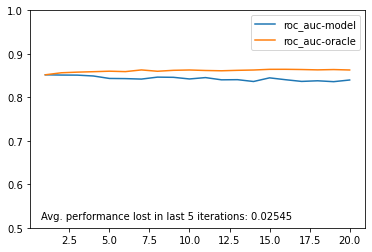

Sampling Bias: 0.02545


In [4]:
# calculate performance loss over the last 5 years
last_n_years = 5
bias = h.measure_bias(metrics["oracle"]["holdout"]['roc_auc'], metrics["model"]["holdout"]['roc_auc'], last_n_years)

# Plot simulation results
x = range(1, n_years + 1)
plt.plot(x, metrics["model"]["holdout"]['roc_auc'], label = 'roc_auc-model')
plt.plot(x, metrics["oracle"]["holdout"]['roc_auc'], label = 'roc_auc-oracle')
plt.text(0.75, 0.52, f'Avg. performance lost in last {last_n_years} iterations: {round(bias, 5)}')
plt.legend()
plt.ylim([0.5, 1.0])
plt.show()


print(f'Sampling Bias: {round(bias, 5)}')

As we can clearly see, as the number of iterations increases the oracle clearly out performs the model. Over the last five years, the average sampling-bias caused performance loss is about 3 percentage points.

#### 4.3 How could an Autoencoder help with sampling selection bias? - Loss Function

The idea that we persue in this project, is to build an autoencoder that represents credit scoring data in a way that looks very similar for GOOD and BAD applications, to avoid any sampling bias that ocours from seeing only one "kind" of data, charachterized by different distributions of feature values. At the same time this representation needs to preserve as much of the original avaliable information as possible.

Arguably the most important part of our project is the way we intend to train our Autoencoder. We would not expect a vanilla Autoencoder that only compresses the data to a latent feature space to have any positive effect on the sampling bias. It is however not per se impossible that a simple compression improves the sampling bias. If we get lucky, the latent feature space lacks parts of the data that are more responsible for the sampling bias than others. This thus of course implies that we could also get unlucky and obtain a representation of the data which distributions are even more skewed between GOOD and BAD samples. In the next part of this notebook we will investigate the effect on the sampling bias of vanilla, compression-only, autoencoders further.

To favour the training of latent feature spaces where the distributions of features for the GOOD and BAD subset of the data are as alike as possible, we explicitly tell the Autoencoder to create them. This is done via the _loss function_.

In fact, we have to objectives we want our autoencoder to keep in mind while training its weights and therefore a latent space representation of our data.

1. Preserve as much of the originally available information as possible.
1. The distribution of feature values should look as similar as possible for the GOOD (accepted) and BAD (rejected) subset of the data.

Important to note is the fact that we made the simplification of GOOD = accepted and BAD = rejected in the autoencoder training process. We argue that it is reasonable to do this simplification, since we know from extensive testing in the previous part, that our models fit the data very well and effortlessly perform with ROC-AUCs around 85%. Thus the error we make compared to using actually predicted rejected and accepted labels is relatively small, whereas the simplification in code and training time is very large.

Additionally, for the same reason, we train the autoencoder on the whole dataset before our actual simulation of the credit granting process takes place. That is again unrealistic and even impossible in the real world, but a neccesary simplification in our setup to run the simulations in a feasible time. We are foremost interessted in the proof of concept of building an autoencoder that helps with reject inference and to explore which parameters make it work or fail.

To train our autoencoder along our two objectives we implemented the follwoing function.

In [ ]:
# train any net
def train(net, trainloader, epochs, learningrate, lossFuncWeights, verbose = True):
    criterion = nn.MSELoss()
    criterion2 = nn.KLDivLoss(log_target=True, reduction="batchmean")
    criterion3 = mmd.MMD_loss()
    optimizer = optim.Adam(net.parameters(), lr=learningrate)

    train_loss = []
    train_loss_mmse = []
    train_loss_mmd = []
    train_loss_kld = []
    for epoch in range(epochs):
        running_loss = 0.0
        running_loss_mmse = 0.0
        running_loss_mmd = 0.0
        running_loss_kld = 0.0
        for data in trainloader:
            data_x, data_y = data
            optimizer.zero_grad()
            outputs = net(data_x)
            encoded = net.encode(data_x)

            # split encoded data into good and bad subsets
            good = [True if x == 0 else False for x in data_y]
            enc_good = encoded[good]
            enc_bad = encoded[[not value for value in good]]
            #print(f'Enc_good shape: {enc_good.shape} Enc_bad shape: {enc_bad.shape}')

            # build MultiNorm Distributions from subsets and create log_probs of GOOD samples for both distributions to compare with KLDIVLOSS
            MN_dist_good = dis.multivariate_normal.MultivariateNormal(torch.mean(enc_good, dim=0), torch.corrcoef(torch.transpose(enc_good, 0, 1)))
            MN_dist_bad = dis.multivariate_normal.MultivariateNormal(torch.mean(enc_bad, dim=0), torch.corrcoef(torch.transpose(enc_bad, 0, 1)))

            sample = MN_dist_good.sample((1000,))

            enc_good = enc_good[:min([len(enc_good),len(enc_bad)])]
            enc_bad = enc_bad[:min([len(enc_good),len(enc_bad)])]

            # calculate criterions only if they influence the overall loss
            MMSELoss = criterion(outputs, data_x)                                                           if lossFuncWeights[0] > 0.0 else torch.zeros(1)
            KLDivLoss = criterion2(MN_dist_bad.log_prob(sample), MN_dist_good.log_prob(sample))  * 1000000  if lossFuncWeights[1] > 0.0 else torch.zeros(1)
            MMDLoss = criterion3(enc_good,enc_bad) * 10                                                     if lossFuncWeights[2] > 0.0 else torch.zeros(1)

            loss = lossFuncWeights[0] * MMSELoss + lossFuncWeights[1] * KLDivLoss + lossFuncWeights[2] * MMDLoss

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_loss_mmse += MMSELoss.item()
            running_loss_mmd += MMDLoss.item()
            running_loss_kld += KLDivLoss.item()

        loss = running_loss / len(trainloader)
        MMSELoss = running_loss_mmse / len(trainloader)
        MMDLoss = running_loss_mmd / len(trainloader)
        KLDivLoss = running_loss_kld / len(trainloader)
        train_loss.append(loss)
        train_loss_mmse.append(MMSELoss)
        train_loss_mmd.append(MMDLoss)
        train_loss_kld.append(KLDivLoss)
        
        if verbose: print('Epoch {} of {}, Train Loss: {:.4f} (MMSE: {:.4f} | MMD: {:.4f} | KLD: {:.4f})'.format(epoch+1, epochs, loss, MMSELoss, MMDLoss, KLDivLoss))

    return train_loss, train_loss_mmse, train_loss_mmd, train_loss_kld

The function is capable of training any torch network along a three part loss function. The three loss criterions we chose to implement are the Minimum Mean Squared Error Loss (MMSELoss) for the standard reconstruction term and the Kullback-Leibler-Divergence (KLDivLoss) as well as the Maximum Mean Discrepancy (MMD_loss) as a penalty for unlike distributions between the GOOD and BAD subset of our data. Both the KLD and the MMD are a measure for the _distance_ between two distributions and have smaller values for distributions that look more alike, which is a property we want our latent feauture space to have.

The function implements a very standard way to train neural networks in pytorch using a data loader that provides batches and multiple epochs that each exhaust all available batches. The thing that is special for our train function is the way we incorporate the distribution missmatch penalty. The KLDivLoss is a predefined pytorch loss function, that is capable of operating on batches, which is very convinient. With it we want to penalize, so increase the overall loss, if the encoder part of our autoencoder does not find a compression of the data that has alike statistical properties for the GOOD and BAD subset of our data. The KLDivLoss method expects the log-likelihood of a sample comming from the two distributions it compares. To obtain these log-likelihoods we therfore create two multivariate normal distributions from the encoded GOOD and BAD subsets of each batch. We then generate 1.000 samples from the GGOD distribution to calculate the log-likelihood of the samples comming from either distribution. If the distributions are very alike, the log-likelihoods will also be alike, resulting in a lower loss.

We also calculate the MMDLoss, which operates directly on the encoded batch data. The GOOD and BAD subset need to be of the same size, though.

Together with the basic MMSE reconstruction error, that compares the decoded net output to the original input, the two loss criterions are weighted and summed into the overall loss. Along this loss, the ADAM optimizer updates the network.

To later plot the loss function components individually we keep track of them and return them after the training is complete.

## 5. Testing and Results

Let's put everything together now. To make use of all the code fragments of this notebooks previous parts we import the classes they belong to from seperate python files.

In [3]:
import sys
sys.path.append('../src')

import importlib
# The dynamic acceptance loop simulation
import dyn_accept_loop as dal
importlib.reload(dal)
# Helper functions
import helper as h
importlib.reload(h)
# The Autoencoder
import autoencoder as aenc
importlib.reload(aenc)

import matplotlib.pyplot as plt

import lightgbm as lgbm
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import torch

import lightgbm as lgbm

#### Compression-only

To see if the autoencoder has a realistic chance to reduce the sampling bias and improve the models performance we need to check if the data at hand is compressible at all. We opted to use the _gmsc_ data set mostly, mainly because its size and the fact that it is not too biased towards the GOOD samples. Also, it is purly numerical which is benefitial for our autoencoder experiments, as we then know we dont use any performance due to WOE effects.

Lets use the simulation class to obtain a baseline to test the effect of a vanilla autoencoder agianst. The simulation iterates over 20 years and we are interested on the models performance over the last 5 years.

Baseline Sampling Bias: 0.03415
Baseline ROC-AUC: 0.83035


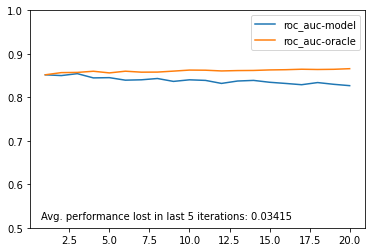

In [6]:
# Define number of iterations and model to use
n_years = 20
model = lgbm.LGBMClassifier()

sim = dal.Simulate_acceptance_loop("gmsc.csv", model, 0.1, 0.1, n_years, enc_features=False, rej_inf=None)
results_generator = sim.run()

metrics = None
for iteration in results_generator:
    metrics = iteration[3]

# calculate performance loss against oracle and models average ROC-AUC over the last 5 years
last_n_years = 5
baseline_bias = h.measure_bias(metrics["oracle"]["holdout"]['roc_auc'], metrics["model"]["holdout"]['roc_auc'], last_n_years)
baseline_roc_auc = sum(metrics["model"]["holdout"]['roc_auc'][-last_n_years:]) / last_n_years
print(f'Baseline Sampling Bias: {round(baseline_bias, 5)}\nBaseline ROC-AUC: {round(baseline_roc_auc, 5)}')

# Plot simulation results
x = range(1, n_years + 1)
plt.plot(x, metrics["model"]["holdout"]['roc_auc'], label = 'roc_auc-model')
plt.plot(x, metrics["oracle"]["holdout"]['roc_auc'], label = 'roc_auc-oracle')
plt.text(0.75, 0.52, f'Avg. performance lost in last {last_n_years} iterations: {round(baseline_bias, 5)}')
plt.legend()
plt.ylim([0.5, 1.0])
plt.show()

Over the last 5 years of this simulation, the model on average, performed with a ROC-AUC of about 0.83 and lost abour 3.5 percentage points against the theoretical best possible performance. Let's now train a simple autoencoder, that only aims to compress the data in the most reconstructable way. We do this, by setting the loss function weights for our distribution missmatch penalities to 0.0.

The original gmsc data set has 68 features. We can set the autoencoder to try and compress it to five, for example. In between the latent layer we aim to train, lets set hidden layers of an intermediate size, to allow for more freedom in the compression for our network.

Autoencoder(
  (enc): ModuleList(
    (0): Linear(in_features=68, out_features=35, bias=True)
    (1): Linear(in_features=35, out_features=5, bias=True)
  )
  (dec): ModuleList(
    (0): Linear(in_features=5, out_features=35, bias=True)
    (1): Linear(in_features=35, out_features=68, bias=True)
  )
)
Epoch 1 of 20, Train Loss: nan (MMSE: 0.8619 | MMD: 0.0000 | KLD: nan)
Epoch 2 of 20, Train Loss: nan (MMSE: 0.6649 | MMD: 0.0000 | KLD: nan)
Epoch 3 of 20, Train Loss: nan (MMSE: 0.6100 | MMD: 0.0000 | KLD: nan)
Epoch 4 of 20, Train Loss: nan (MMSE: 0.5768 | MMD: 0.0000 | KLD: nan)
Epoch 5 of 20, Train Loss: nan (MMSE: 0.5620 | MMD: 0.0000 | KLD: nan)
Epoch 6 of 20, Train Loss: nan (MMSE: 0.5505 | MMD: 0.0000 | KLD: nan)
Epoch 7 of 20, Train Loss: nan (MMSE: 0.5419 | MMD: 0.0000 | KLD: nan)
Epoch 8 of 20, Train Loss: nan (MMSE: 0.5352 | MMD: 0.0000 | KLD: nan)
Epoch 9 of 20, Train Loss: nan (MMSE: 0.5289 | MMD: 0.0000 | KLD: nan)
Epoch 10 of 20, Train Loss: nan (MMSE: 0.5231 | MMD: 0.000

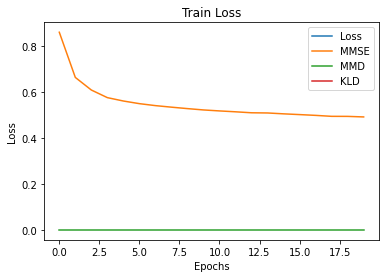

In [9]:
BATCH_SIZE = 2000
EPOCHS = 20
LR = 1e-2
# ONLY MMSE as single loss term for this first experiment
LOSSFUNCWEIGHTS = [1.0 ,0.0, 0.0]  #[MMSE, KLDiv, MMD]

dataset = aenc.CreditscoringDataset("gmsc.csv")      # load and prepare Dataset to Tensor
data_loader = aenc.DataLoader(                       # create Dataloader for batching
    dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

shape = [dataset.x.shape[1], 35, 5, 35, dataset.x.shape[1]]  # define shape of Autoencoder
net = aenc.Autoencoder(shape)
print(net)
net.to("cpu")

train_loss, train_loss_mmse, train_loss_mmd, train_loss_kld = aenc.train(net, data_loader, EPOCHS, LR, LOSSFUNCWEIGHTS, verbose = True)               

plt.figure()
plt.plot(train_loss, label='Loss')
plt.plot(train_loss_mmse, label='MMSE')
plt.plot(train_loss_mmd, label='MMD')
plt.plot(train_loss_kld, label='KLD')
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

We can now use the trained autoencoder and pass it to our simulation class, to see the simulation beeing run on the encoded (to five latent features!) data.

Sampling Bias on encoded data: 0.01498
Sampling Bias encoded model against original unencoded baseline: 0.02954
ROC-AUC on encoded data: 0.83496


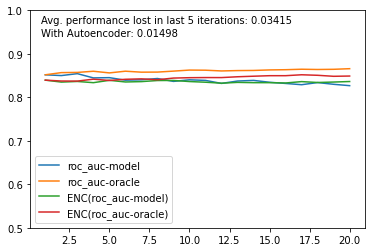

In [14]:
n_years = 20

# Pass encoder in encoder parameter and set enc_features to True
sim = dal.Simulate_acceptance_loop("gmsc.csv", model, 0.1, 0.1, n_years, enc_features=True, encoder=net)
results_generator = sim.run()

metrics2 = None
for iteration in results_generator:
    metrics2 = iteration[3]

last_n_years = 5
bias2 = h.measure_bias(metrics2["oracle"]["holdout"]['roc_auc'], metrics2["model"]["holdout"]['roc_auc'], last_n_years)
bias2vsOriginal = h.measure_bias(metrics["oracle"]["holdout"]['roc_auc'], metrics2["model"]["holdout"]['roc_auc'], last_n_years)
roc_auc2 = sum(metrics2["model"]["holdout"]['roc_auc'][-last_n_years:]) / last_n_years
print(f'Sampling Bias on encoded data: {round(bias2, 5)}\nSampling Bias encoded model against original unencoded baseline: {round(bias2vsOriginal, 5)}\nROC-AUC on encoded data: {round(roc_auc2, 5)}')
    
x = range(1, n_years + 1)
plt.plot(x, metrics["model"]["holdout"]['roc_auc'], label = 'roc_auc-model')
plt.plot(x, metrics["oracle"]["holdout"]['roc_auc'], label = 'roc_auc-oracle')
plt.plot(x, metrics2["model"]["holdout"]['roc_auc'], label = 'ENC(roc_auc-model)')
plt.plot(x, metrics2["oracle"]["holdout"]['roc_auc'], label = 'ENC(roc_auc-oracle)')
plt.text(0.75, 0.97, f'Avg. performance lost in last {last_n_years} iterations: {round(baseline_bias, 5)}')
plt.text(0.75, 0.94, f'With Autoencoder: {round(bias2, 5)}')
plt.legend()
plt.ylim([0.5, 1.0])
plt.show()

This looks good! The encoded data holds enough information to allow our model to perform with a nearly identical AUC! Also, we noticebly reduced the sampling bias in the encoded case! That is however mostly because we lost a lot of performance in the oracle model on encoded data. Compared to the ture baseline we did not shrink the sampling bias much. (Which is also not really expected at this stage of course...)

### With Distribution Missmatch Penalty

Lets now add some distribution missmatch penalty to the loss function and hope it improves our results. To give back a little bit more freedome to the net and because we dont really care for the number of latent features, we can increase the latent feature size again a little.

Autoencoder(
  (enc): ModuleList(
    (0): Linear(in_features=68, out_features=45, bias=True)
    (1): Linear(in_features=45, out_features=25, bias=True)
  )
  (dec): ModuleList(
    (0): Linear(in_features=25, out_features=45, bias=True)
    (1): Linear(in_features=45, out_features=68, bias=True)
  )
)
Epoch 1 of 20, Train Loss: 1.1058 (MMSE: 0.2212 | MMD: 0.0000 | KLD: 0.8847)
Epoch 2 of 20, Train Loss: 0.9802 (MMSE: 0.1960 | MMD: 0.0000 | KLD: 0.7842)
Epoch 3 of 20, Train Loss: 0.9665 (MMSE: 0.1933 | MMD: 0.0000 | KLD: 0.7732)
Epoch 4 of 20, Train Loss: 0.9505 (MMSE: 0.1901 | MMD: 0.0000 | KLD: 0.7604)
Epoch 5 of 20, Train Loss: 0.9156 (MMSE: 0.1831 | MMD: 0.0000 | KLD: 0.7325)
Epoch 6 of 20, Train Loss: 0.9080 (MMSE: 0.1816 | MMD: 0.0000 | KLD: 0.7264)
Epoch 7 of 20, Train Loss: 0.8870 (MMSE: 0.1774 | MMD: 0.0000 | KLD: 0.7096)
Epoch 8 of 20, Train Loss: 0.8576 (MMSE: 0.1715 | MMD: 0.0000 | KLD: 0.6861)
Epoch 9 of 20, Train Loss: 0.8275 (MMSE: 0.1655 | MMD: 0.0000 | KLD: 0.6620)
Ep

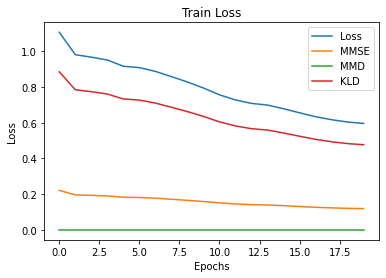

In [19]:
BATCH_SIZE = 2000
EPOCHS = 20
LR = 1e-3
# MMSE + KLDiv
LOSSFUNCWEIGHTS = [0.2, 0.8, 0.0]  #[MMSE, KLDiv, MMD]

dataset = aenc.CreditscoringDataset("gmsc.csv")      # load and prepare Dataset to Tensor
data_loader = aenc.DataLoader(                       # create Dataloader for batching
    dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

shape = [dataset.x.shape[1], 45, 25, 45, dataset.x.shape[1]]  # define shape of Autoencoder
net = aenc.Autoencoder(shape)
print(net)
net.to("cpu")

train_loss, train_loss_mmse, train_loss_mmd, train_loss_kld = aenc.train(net, data_loader, EPOCHS, LR, LOSSFUNCWEIGHTS, verbose = True)               

plt.figure()
plt.plot(train_loss, label='Loss')
plt.plot(train_loss_mmse, label='MMSE')
plt.plot(train_loss_mmd, label='MMD')
plt.plot(train_loss_kld, label='KLD')
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Sampling Bias on encoded data: 0.02227
Sampling Bias encoded model against original unencoded baseline: 0.02619
ROC-AUC on encoded data: 0.83832


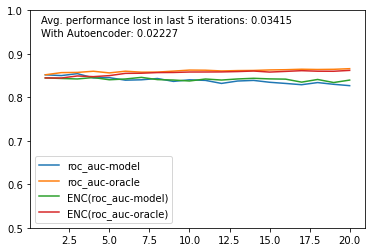

In [20]:
# Pass encoder in encoder parameter and set enc_features to True
sim = dal.Simulate_acceptance_loop("gmsc.csv", model, 0.1, 0.1, n_years, enc_features=True, encoder=net)
results_generator = sim.run()

metrics2 = None
for iteration in results_generator:
    metrics2 = iteration[3]

last_n_years = 5
bias2 = h.measure_bias(metrics2["oracle"]["holdout"]['roc_auc'], metrics2["model"]["holdout"]['roc_auc'], last_n_years)
bias2vsOriginal = h.measure_bias(metrics["oracle"]["holdout"]['roc_auc'], metrics2["model"]["holdout"]['roc_auc'], last_n_years)
roc_auc2 = sum(metrics2["model"]["holdout"]['roc_auc'][-last_n_years:]) / last_n_years
print(f'Sampling Bias on encoded data: {round(bias2, 5)}\nSampling Bias encoded model against original unencoded baseline: {round(bias2vsOriginal, 5)}\nROC-AUC on encoded data: {round(roc_auc2, 5)}')
    
x = range(1, n_years + 1)
plt.plot(x, metrics["model"]["holdout"]['roc_auc'], label = 'roc_auc-model')
plt.plot(x, metrics["oracle"]["holdout"]['roc_auc'], label = 'roc_auc-oracle')
plt.plot(x, metrics2["model"]["holdout"]['roc_auc'], label = 'ENC(roc_auc-model)')
plt.plot(x, metrics2["oracle"]["holdout"]['roc_auc'], label = 'ENC(roc_auc-oracle)')
plt.text(0.75, 0.97, f'Avg. performance lost in last {last_n_years} iterations: {round(baseline_bias, 5)}')
plt.text(0.75, 0.94, f'With Autoencoder: {round(bias2, 5)}')
plt.legend()
plt.ylim([0.5, 1.0])
plt.show()

That looks even better! The ROC-AUC of the model operating on the encoded data is now noticably higher than on the unencoded data. This can also be seen by the smaller sampling bias against the unencoded baseline!

Of course there are a lot of parameters in play here and up until now we only randomly set them. It would make a lot more sense to look at them and their effect on the model performance in a bigger range, to asses their influence better.

A side note on the MMD Loss: We found it to not work properly at all and in any configuration drastically lower the model performance while at the same time beeing very slow to train. We exclude it in any further experiments, but leave it in the code to show that it theoretically can be used in future testing and development.

We will now have a look at the effect the number of latent features has on the model performance and compare that to our baseline performance.

PARAM: 3 | Sampling Bias: 0.16956 // ROC-AUC: 0.69494
PARAM: 5 | Sampling Bias: 0.13928 // ROC-AUC: 0.72523
PARAM: 7 | Sampling Bias: 0.12309 // ROC-AUC: 0.74142
PARAM: 9 | Sampling Bias: 0.07162 // ROC-AUC: 0.79289
PARAM: 11 | Sampling Bias: 0.03711 // ROC-AUC: 0.82739
PARAM: 13 | Sampling Bias: 0.04039 // ROC-AUC: 0.82411
PARAM: 15 | Sampling Bias: 0.03159 // ROC-AUC: 0.83292
PARAM: 17 | Sampling Bias: 0.03329 // ROC-AUC: 0.83122
PARAM: 19 | Sampling Bias: 0.03392 // ROC-AUC: 0.83058
PARAM: 21 | Sampling Bias: 0.02981 // ROC-AUC: 0.83469
PARAM: 23 | Sampling Bias: 0.03365 // ROC-AUC: 0.83086
PARAM: 25 | Sampling Bias: 0.03119 // ROC-AUC: 0.83332
PARAM: 27 | Sampling Bias: 0.03398 // ROC-AUC: 0.83052
PARAM: 29 | Sampling Bias: 0.02812 // ROC-AUC: 0.83639
PARAM: 31 | Sampling Bias: 0.02286 // ROC-AUC: 0.84165
PARAM: 33 | Sampling Bias: 0.02519 // ROC-AUC: 0.83932


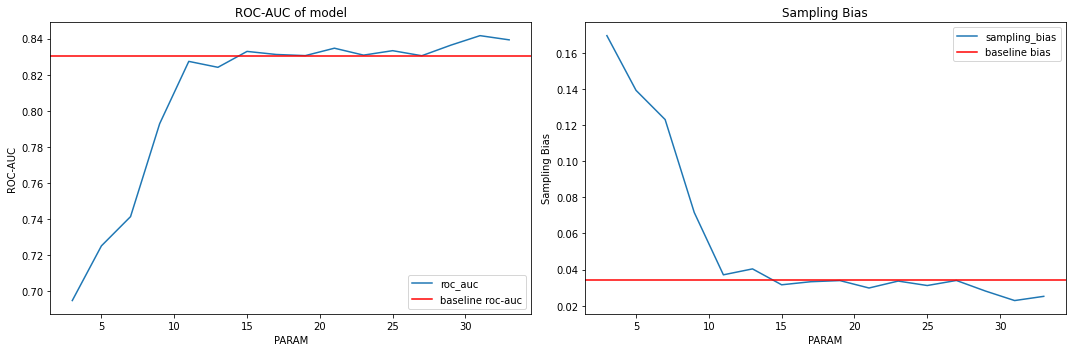

In [21]:
## -----------------------------------------------------------------------
## Loop through Autoencoder training and testing for a parameter
## -----------------------------------------------------------------------

BATCH_SIZE = 2000
EPOCHS = 20
LR = 1e-3

sampling_bias = []
roc_auc = []
startvalue = 3
stopvalue = 35
step = 2
for PARAM in range(startvalue, stopvalue, step):
    # Train Autoencoder
    LOSSFUNCWEIGHTS = [0.2, 0.8, 0.0]  #[MMSE, KLDiv, MMD]

    dataset = aenc.CreditscoringDataset("gmsc.csv")      # load and prepare Dataset to Tensor
    data_loader = aenc.DataLoader(                       # create Dataloader for batching
        dataset, 
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=True
    )

    shape = [dataset.x.shape[1], 45, PARAM, 45, dataset.x.shape[1]]  # define shape of Autoencoder PARAM = 25
    net = aenc.Autoencoder(shape)
    #print(net)
    net.to("cpu")

    train_loss, train_loss_mmse, train_loss_mmd, train_loss_kld = aenc.train(net, data_loader, EPOCHS, LR, LOSSFUNCWEIGHTS, verbose=False)

    # Simulate on encoded Data to measure sampling bias

    sim = dal.Simulate_acceptance_loop("gmsc.csv", model, 0.1, 0.1, n_years, enc_features=True, encoder=net)#, rej_inf=rinf.EMsemisupervised)
    results_generator = sim.run()

    metrics2 = None
    for iteration in results_generator:
        #print(f'Itteration: {iteration[0]}) Accepted: {iteration[1].count(True)} | Denied: {iteration[1].count(False)} - New train set size: {iteration[2]}')
        metrics2 = iteration[3]


    sampling_bias.append(h.measure_bias(metrics["oracle"]["holdout"]['roc_auc'], metrics2["model"]["holdout"]['roc_auc'], last_n_years))
    roc_auc.append(sum(metrics2["model"]["holdout"]['roc_auc'][-last_n_years:]) / last_n_years)
    print(f'PARAM: {PARAM} | Sampling Bias: {round(sampling_bias[-1], 5)} // ROC-AUC: {round(roc_auc[-1], 5)}')

# Plot Results
x = range(startvalue, stopvalue, step)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot(x, roc_auc, label = 'roc_auc')
axes[0].axhline(y = baseline_roc_auc, color = 'r', label = 'baseline roc-auc')
axes[0].legend()
axes[0].set_title("ROC-AUC of model")
axes[0].set_ylabel("ROC-AUC")
axes[0].set_xlabel("PARAM")

axes[1].plot(x, sampling_bias, label = 'sampling_bias')
axes[1].axhline(y = baseline_bias, color = 'r', label = 'baseline bias')
axes[1].legend()
axes[1].set_title("Sampling Bias")
axes[1].set_ylabel("Sampling Bias")
axes[1].set_xlabel("PARAM")
fig.tight_layout()